# Setting up a latent function Gaussian Process

Let us start by importing Turing.jl, the library we will use to write our statistical model and our GaussianProcess.jl package. \
The rest of the imports will only be used to generate the data and plot. 

In [1]:
# import set 1
using Turing
using Distances
using LinearAlgebra
using LimberJack

    CondaPkg Found dependencies: /Users/vis/.julia/packages/CondaPkg/0UqYV/CondaPkg.toml
    CondaPkg Found dependencies: /Users/vis/.julia/packages/PythonCall/mkWc2/CondaPkg.toml
    CondaPkg Found dependencies: /Users/vis/.julia/packages/IJulia/y8YGF/CondaPkg.toml
    CondaPkg Initialising pixi
             │ /Users/vis/.julia/artifacts/d2fecc2a9fa3eac2108d3e4d9d155e6ff5dfd0b2/bin/pixi
             │ init
             │ --format pixi
             └ /Users/vis/Desktop/MSci Project - UCL 2025-26/Cosmography_GP/.CondaPkg
✔ Created /Users/vis/Desktop/MSci Project - UCL 2025-26/Cosmography_GP/.CondaPkg/pixi.toml
    CondaPkg Wrote /Users/vis/Desktop/MSci Project - UCL 2025-26/Cosmography_GP/.CondaPkg/pixi.toml
             │ [dependencies]
             │ openssl = ">=3, <3.6"
             │ jupyter_kernel_test = "*"
             │ jupyter_client = "*"
             │ 
             │     [dependencies.python]
             │     channel = "conda-forge"
             │     build = "*cp*"
     

In [2]:
# import set 2
using Interpolations
using GaussianProcess
using Plots
using QuadGK
using BlockDiagonals

### 1. Collate Hz and Dm data

In [3]:
# setting a cosmology for the fake data 
cosmo1 = Cosmology();

#### Hz data

In [4]:
function CC()
    z = [
        0.07, 0.09, 0.12, 0.17, 0.179, 0.199, 0.2,
        0.27, 0.28, 0.352, 0.38, 0.3802, 0.4,
        0.4004, 0.4247, 0.44, 0.4497, 0.47, 0.4783,
        0.48, 0.51, 0.593, 0.6, 0.61, 0.68, 0.73,
        0.781, 0.875, 0.88, 0.9, 1.037, 1.3,
        1.363, 1.43, 1.53, 1.75, 1.965
    ]

    data = [
        69.0, 69.0, 68.6, 83.0, 75.0, 75.0, 72.9,
        77.0, 88.8, 83.0, 81.5, 83.0, 95.0, 77.0,
        87.1, 82.6, 92.8, 89.0, 80.9, 97.0, 90.4,
        104.0, 87.9, 97.3, 92.0, 97.3, 105.0,
        125.0, 90.0, 117.0, 154.0, 168.0, 160.0,
        177.0, 140.0, 202.0, 186.5
    ]

    err = [
        19.6, 12.0, 26.2, 8.0, 4.0, 5.0, 29.6,
        14.0, 36.6, 14.0, 1.9, 13.5, 17.0, 10.2,
        11.2, 7.8, 12.9, 23.0, 9.0, 62.0, 1.9,
        13.0, 6.1, 2.1, 8.0, 7.0, 12.0, 17.0,
        40.0, 23.0, 20.0, 17.0, 33.6, 18.0,
        14.0, 40.0, 50.4
    ]

    cov = zeros(length(z), length(z))
    for i in 1:length(z)
        cov[i, i] = err[i]^2
    end

    return (
        data_name = "CC",
        z = z,
        data = data,
        cov = cov
    )
end


CC (generic function with 1 method)

In [5]:
function BOSSDR12()
    z = [0.38, 0.51, 0.61]
    data = [81.2087, 90.9029, 98.9647]
    cov = [5.00049e+02 2.94536e+02 1.42011e+02; 2.94536e+02 7.02299e+02 4.32750e+02; 1.42011e+02 4.32750e+02 1.01718e+03]
    return (data_name = "BOSSDR12", z = z, data = data, cov = cov)
end

BOSSDR12 (generic function with 1 method)

#### Dm data

In [6]:
function BOSSDR12_dm()
    z = [0.025, 0.08, 0.1, 0.25, 0.51, 0.63, 0.79, 0.94, 0.96, 1.3, 1.49, 2.05, 2.3]
    data = comoving_radial_distance(cosmo1, z)
    err = 0.1*data
    cov = zeros(length(z), length(z))
    for i in 1:length(z)
        cov[i, i] = err[i]^2
    end
    return (data_name = "BOSSDR12_dm", z = z, data = data, cov = cov)
end

BOSSDR12_dm (generic function with 1 method)

#### fs8 data

In [7]:
function fakedata_fs8()
    z = [0.02, 0.07, 0.2, 0.5, 0.6, 0.77, 0.9, 1.1, 2.0, 2.05]
    data = fs8(cosmo1, z)
    err = 0.1*data
    cov = zeros(length(z), length(z))
    for i in 1:length(z)
        cov[i, i] = err[i]^2
    end
    return(data_name = "fakedata_fs8", z=z, data=data, cov=cov)
end

fakedata_fs8 (generic function with 1 method)

#### Putting Hz, Dm and fs8 data together

In [8]:
cc = CC();
bossdr12 = BOSSDR12();
bossdr12dm = BOSSDR12_dm();
fakedatafs8 = fakedata_fs8();

In [9]:
# observed data 
observations  = [bossdr12.data; cc.data; bossdr12dm.data; fakedatafs8.data];
z_obs = [bossdr12.z; cc.z; bossdr12dm.z; fakedatafs8.z];

In [10]:
covariance_obs = BlockDiagonal([bossdr12.cov,cc.cov,bossdr12dm.cov,fakedatafs8.cov]);

### 2. Priors

In [11]:
zlat = range(0, 3.0, length=24); # latent variable space
z_integ = range(0, 3.0, length=100);

In [12]:
# preset parameter values
omegam = cosmo1.cpar.Ωm
s8 = cosmo1.cpar.σ8
hc = cosmo1.cpar.h
omegab = cosmo1.cpar.Ωb

0.05

In [13]:
function model_latent_GP(eta, l, v; omega_m=omegam, sigma_8=s8,
                         x=zlat, z=z_obs, data_cov=covariance_obs)
    # Dimensions of predictors .
    kernel = sqexp_cov_fn(x; eta=eta, l=l)
    cpar = CosmoPar(Ωm=omega_m,  Ωb=omegab, h=hc, σ8=sigma_8)
    mean_hx = cpar.h*100*Ez(cpar, x)
    #mean_hx = cosmo1.cpar.h*100*Ez(cosmo1, x)
    # a latent GP is carried out using a Wiener filter
    hx = latent_GP(mean_hx, v, kernel)
    # transforms hx from x space to z space
    hz =  conditional(x, z, hx, sqexp_cov_fn;
                     eta=eta, l=l)
    return hx, hz
end

model_latent_GP (generic function with 1 method)

hx is the GP realisation of the hubble parameter. hz transforms hx from the latent space to another parameter space (integral or observation).

In [14]:
N_samples = 100
# data parameter space conditional
hxs1=zeros(N_samples, 24)
hzs1=zeros(N_samples, length(z_obs))
# pick 100 random hyperparameter combinations, and compute the GP realisation of them in both latent and conditional space.
for i in 1:N_samples
    eta = 200*rand(Uniform(0., 0.1))
    l = 0.02*rand(Uniform(0.1, 3))
    v = rand(MvNormal(zeros(length(zlat)), ones(length(zlat))))
    o_m = rand(Uniform(0.25, 0.35))
    s_8 = rand(Uniform(0.75,0.85))
    hxs1[i, :], hzs1[i, :] = model_latent_GP(eta, l, v; omega_m=o_m, sigma_8=s_8)
end
y_m1, y_s1 = mean(hzs1, dims=1), std(hzs1, dims=1); #observed space
gp_m1, gp_s1 = mean(hxs1, dims=1), std(hxs1, dims=1); #latent space

# integral parameter space conditional
hxs2=zeros(N_samples, 24)
hzs2=zeros(N_samples, length(z_integ))
for i in 1:N_samples
    eta = 200*rand(Uniform(0., 0.1))
    l = 0.02*rand(Uniform(0.1, 3))
    v = rand(MvNormal(zeros(length(zlat)), ones(length(zlat))))
    o_m = rand(Uniform(0.25, 0.35))
    s_8 = rand(Uniform(0.75,0.85))
    hxs2[i, :], hzs2[i, :] = model_latent_GP(eta, l, v; z=z_integ, omega_m=o_m, sigma_8=s_8)
end


y_m2, y_s2 = mean(hzs2, dims=1), std(hzs2, dims=1); #integral space
gp_m2, gp_s2 = mean(hxs2, dims=1), std(hxs2, dims=1); #latent space

In [15]:
function comoving_d(zs, hz_ip)
    chis = zeros(Real, length(zs))
    for i in 1:length(zs)
        zz = zs[i]
        chis[i] = quadgk(z -> 1.0/hz_ip(z), 0.0, zz, rtol=1E-5)[1]
        chis[i] *= 300000


    end
    chii = linear_interpolation(zs, vec(chis), extrapolation_bc=Line())
    return chii
end


comoving_d (generic function with 1 method)

In [16]:
# Hz integral interpolator - prior
hz_itp = linear_interpolation(z_integ, vec(y_m2), extrapolation_bc=Line());
# chi interpolator
chiitp = comoving_d(z_integ, hz_itp);

In [17]:
function get_growth3(zarr, Ωm, σ8, h0, cosmo_type, H_gp)
    nz2 = length(zarr)
    z_max = maximum(zarr)
    x = LinRange(0, log(1+z_max), nz2)
    z = @.(exp(x) - 1)
    a = @.(1/(1+z))
    dx = x[2]-x[1]
    
    aa = reverse(a)
    # put the gp H(z) here
    #e = Ez(cpar, z) - output is vector::float64
    # match the Ez output type to the hz thing
    e = H_gp(z)/(h0*100)
    ee = reverse(e)
    # removed type for now, may cry later. 
    # sample: dd = zeros(settings.cosmo_type(Float64), settings.nz)
    dd = zeros(cosmo_type, nz2)
    yy = zeros(cosmo_type, nz2)
    dd[1] = aa[1]
    yy[1] = aa[1]^3*ee[end]
    
    for i in 1:(nz2-1)
        A0 = -1.5 * Ωm / (aa[i]*ee[i])
        B0 = -1. / (aa[i]^2*ee[i])
        A1 = -1.5 * Ωm / (aa[i+1]*ee[i+1])
        B1 = -1. / (aa[i+1]^2*ee[i+1])
        yy[i+1] = (1+0.5*dx^2*A0*B0)*yy[i] + 0.5*(A0+A1)*dx*dd[i]
        dd[i+1] = 0.5*(B0+B1)*dx*yy[i] + (1+0.5*dx^2*A0*B0)*dd[i]
    end
    
    y = reverse(yy)
    d = reverse(dd)

    fs8zi = linear_interpolation(z, -σ8 .* y./ (a.^2 .*e.*d[1]),
                                 extrapolation_bc=Line())

    return fs8zi
end

get_growth3 (generic function with 1 method)

In [18]:
# fs8 prior - interpolator
fs8itp = get_growth3(z_integ, cosmo1.cpar.Ωm, cosmo1.cpar.σ8, cosmo1.cpar.h, eltype(hz_itp), hz_itp);

In [19]:
hztest = hz_itp(z_integ)/(hc*100);
eztest = Ez(cosmo1, z_integ);

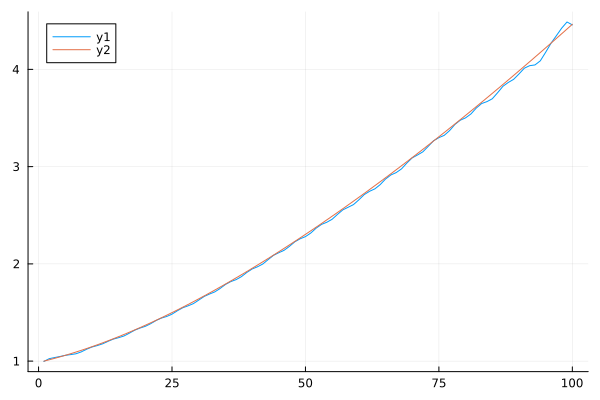

In [20]:
plot(hztest)
plot!(eztest)

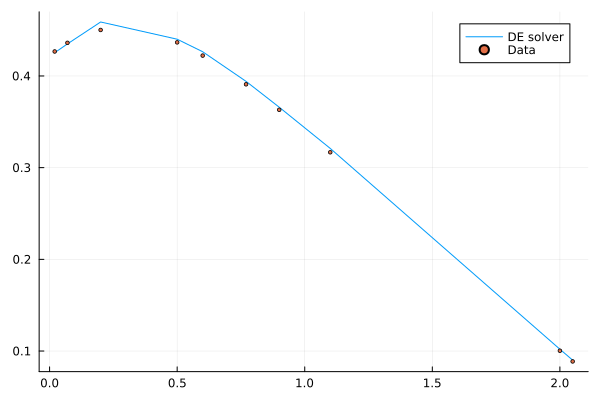

In [21]:
# plotting fs8 data compared 
plot(fakedatafs8.z, 1.16*fs8itp(fakedatafs8.z), label="DE solver")
plot!(fakedatafs8.z, 1.16*(fakedatafs8.data), label="Data", ms=2, seriestype=:scatter)

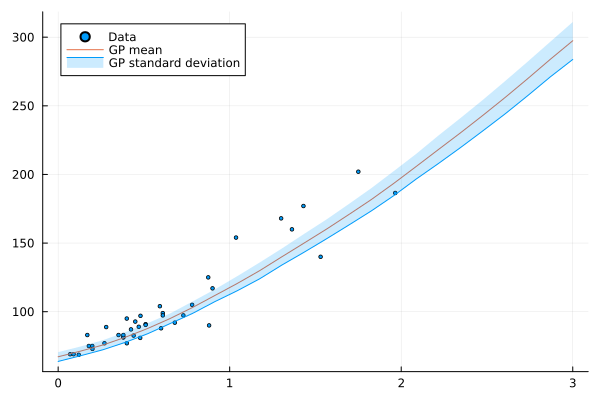

In [22]:
# latent space hz plot
plot(z_obs[1:40], observations[1:40], label="Data", ms=2, seriestype=:scatter)
plot!(zlat, vec(gp_m1), label="GP mean")
plot!(zlat, vec(gp_m1 .- gp_s1),  fillrange = vec(gp_m1 .+ gp_s1), fillalpha=0.2, c=1, label="GP standard deviation")

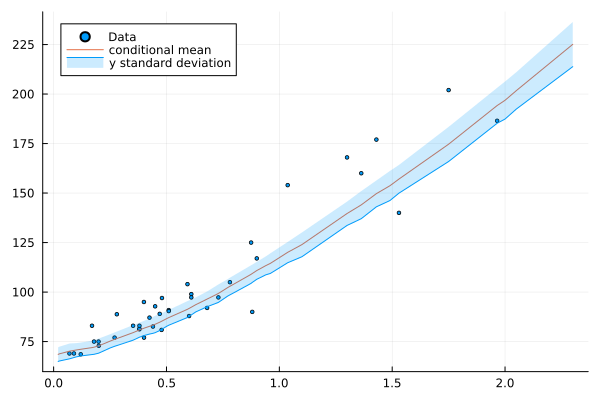

In [23]:
# observed space hz plot grid
plot(z_obs[1:40], observations[1:40], label="Data", ms=2, seriestype=:scatter)
#plot!(zlat, H1)
plot!(sort(z_obs), sort(vec(y_m1)), label="conditional mean")
plot!(sort(z_obs), sort(vec(y_m1 .- y_s1)),  fillrange = sort(vec(y_m1 .+ y_s1)), fillalpha=0.2, c=1, label="y standard deviation")

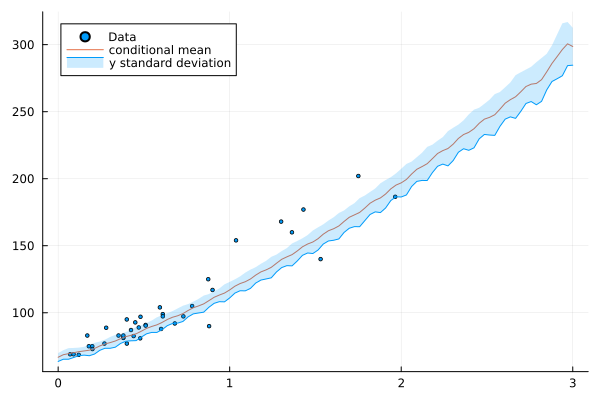

In [24]:
# integrated grid
plot(z_obs[1:40], observations[1:40], label="Data", ms=2, seriestype=:scatter)
#plot!(zlat, H1)
plot!(z_integ, vec(y_m2), label="conditional mean")
plot!(z_integ, vec(y_m2 .- y_s2),  fillrange = vec(y_m2 .+ y_s2), fillalpha=0.2, c=1, label="y standard deviation")

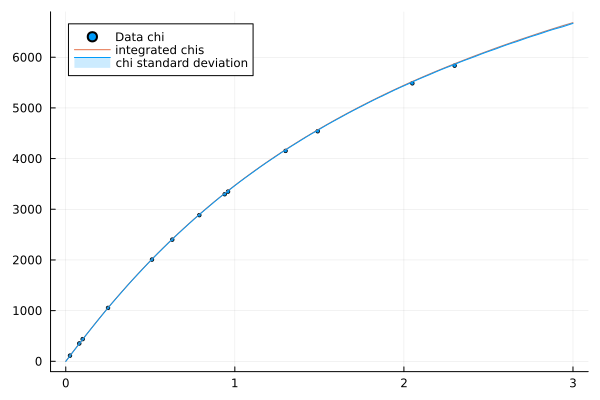

In [25]:
plot(bossdr12dm.z, bossdr12dm.data, label="Data chi", ms=2, seriestype=:scatter)
#chicont = comoving_radial_distance(cosmo1, zlat)
#plot!(zlat, chicont)
chivector = chiitp(z_integ)
plot!(z_integ, chiitp(z_integ), label="integrated chis")
plot!(z_integ, (chivector-vec(y_s2)),  fillrange = (chivector+vec(y_s2)), fillalpha=0.2, c=1, label="chi standard deviation")

### 3. Define our statistical model

In [26]:
@model function stats_model(y; int_grid=z_integ, X=zlat, data_x=z_obs, data_cov=covariance_obs)
    # Priors.
    eta2 ~ 200*Uniform(0.0, 0.1)
    l2 ~ 0.02*Uniform(0.1, 3)
    v2 ~ MvNormal(zeros(length(X)), ones(length(X)))
    omega_m2 ~ Uniform(0.25,0.35)
    sigma8 ~ Uniform(0.75,0.85)
    kernel = sqexp_cov_fn(X, eta=eta2, l=l2)
    cpar = CosmoPar(Ωm=omega_m2,  Ωb=omegab, h=hc, σ8=sigma8)
    mean_hz = cpar.h*100*Ez(cpar, X)
    h_gp = latent_GP(mean_hz, v2, kernel)

    H_int := conditional(X, int_grid, h_gp, sqexp_cov_fn; eta=eta2, l=l2)
    H_int_grid = linear_interpolation(int_grid, H_int)
    chi_interp = comoving_d(int_grid, H_int_grid)
    fs8_interp = get_growth3(int_grid, omega_m2, sigma8, hc, eltype(H_int_grid), H_int_grid);

    hdata := H_int_grid(data_x[1:40])
    chidata := chi_interp(data_x[41:40+length(bossdr12dm.z)])
    fs8data := fs8_interp(data_x[41+length(bossdr12dm.z): end])
    datay = [hdata;chidata;fs8data]

    y = MvNormal(datay, data_cov)

end

stats_model (generic function with 2 methods)

### 4. Sample the model

In [27]:
chain = sample(stats_model(observations), NUTS(20, 0.65), 100)

Sampling   0%|                                          |  ETA: N/A
┌ Info: Found initial step size
│   ϵ = 0.8500000000000001
└ @ Turing.Inference /Users/vis/.julia/packages/Turing/QN7BL/src/mcmc/hmc.jl:212
Sampling   1%|▍                                         |  ETA: 0:41:10
Sampling   2%|▊                                         |  ETA: 0:20:33
Sampling   2%|█                                         |  ETA: 0:13:38
Sampling   3%|█▍                                        |  ETA: 0:10:13
Sampling   4%|█▊                                        |  ETA: 0:08:08
Sampling   5%|██▏                                       |  ETA: 0:06:44
Sampling   6%|██▌                                       |  ETA: 0:05:45
Sampling   7%|██▊                                       |  ETA: 0:05:00
Sampling   8%|███▏                                      |  ETA: 0:04:26
Sampling   8%|███▌                                      |  ETA: 0:03:57
Sampling   9%|███▉                                      |  ETA: 0:03:37


Chains MCMC chain (100×203×1 Array{Float64, 3}):

Iterations        = 21:1:120
Number of chains  = 1
Samples per chain = 100
Wall duration     = 34.51 seconds
Compute duration  = 34.51 seconds
parameters        = eta2, l2, v2[1], v2[2], v2[3], v2[4], v2[5], v2[6], v2[7], v2[8], v2[9], v2[10], v2[11], v2[12], v2[13], v2[14], v2[15], v2[16], v2[17], v2[18], v2[19], v2[20], v2[21], v2[22], v2[23], v2[24], omega_m2, sigma8, H_int[1], H_int[2], H_int[3], H_int[4], H_int[5], H_int[6], H_int[7], H_int[8], H_int[9], H_int[10], H_int[11], H_int[12], H_int[13], H_int[14], H_int[15], H_int[16], H_int[17], H_int[18], H_int[19], H_int[20], H_int[21], H_int[22], H_int[23], H_int[24], H_int[25], H_int[26], H_int[27], H_int[28], H_int[29], H_int[30], H_int[31], H_int[32], H_int[33], H_int[34], H_int[35], H_int[36], H_int[37], H_int[38], H_int[39], H_int[40], H_int[41], H_int[42], H_int[43], H_int[44], H_int[45], H_int[46], H_int[47], H_int[48], H_int[49], H_int[50], H_int[51], H_int[52], H_int[53], H_

In [28]:
hdata_p = group(chain, :hdata).value.data[:,:,1];
chidata_p =  group(chain, :chidata).value.data[:,:,1];
fs8data_p =  group(chain, :fs8data).value.data[:,:,1];

### 5. Check how our posteriors look like

In [29]:
eta_p = group(chain, :eta2).value.data[:, :, 1];
l_p = group(chain, :l2).value.data[:, :, 1];
v_p = group(chain, :v2).value.data[:, :, 1];
omegam_p = group(chain, :omega_m2).value.data[:, :, 1];
s8_p = group(chain, :sigma8).value.data[:, :, 1];

In [30]:
# function model_latent_GP2(eta, l, v; omega_m=omegam, sigma_8=s8,
#                          x=zlat, z=z_obs, data_cov=covariance_obs, data_H=hdata_p)
#     # Dimensions of predictors .
#     kernel = sqexp_cov_fn(x; eta=eta, l=l)
#     cpar = CosmoPar(Ωm=omega_m,  Ωb=omegab, h=hc, σ8=sigma_8)
#     mean_hx = cpar.h*100*Ez(cpar, x)
#     H_datainterp = linear_interpolation(z[1:length(data_H)], data_H)
#     H_cond = H_datainterp(x)
#     #mean_hx = cosmo1.cpar.h*100*Ez(cosmo1, x)
#     # a latent GP is carried out using a Wiener filter
#     hx = latent_GP(mean_hx, v, kernel)
#     hx2 = latent_GP(H_cond, v, kernel)
#     # transforms hx from x space to z space
#     hz =  conditional(x, z, hx, sqexp_cov_fn;
#                      eta=eta, l=l)
#     hz2 =  conditional(x, z, hx2, sqexp_cov_fn;
#                      eta=eta, l=l)                 
#     return hx, hx2, hz, hz2
# end

In [31]:
# N_samples2 = length(eta_p)
# gps3=zeros(N_samples2, 24)
# ys3=zeros(N_samples2, length(z_integ))
# for i in 1:N_samples2
#     gps3[i, :], gp_cond[i,:], ys3[i, :], ys_cond[i, :] = model_latent_GP2(eta_p[i], l_p[i], v_p[i, :]; omega_m=omegam_p[i], sigma_8=s8_p[i], z=z_integ
#                                                 )
# end

# y_m3, y_s3 = mean(ys3, dims=1), std(ys3, dims=1); #integral space
# gp_m3, gp_s3 = mean(gps3, dims=1), std(gps3, dims=1); #latent space
# y_mcond, y_scond = mean(ys3, dims=1), std(ys3, dims=1); 
# gp_mcond, gp_scond = mean(gps3, dims=1), std(gps3, dims=1);

# integral parameter space conditional
# hxs2=zeros(N_samples, 24)
# hzs2=zeros(N_samples, length(z_integ))
# for i in 1:N_samples
#     eta = 200*rand(Uniform(0., 0.1))
#     l = 0.02*rand(Uniform(0.1, 3))
#     v = rand(MvNormal(zeros(length(zlat)), ones(length(zlat))))
#     hxs2[i, :], hzs2[i, :] = model_latent_GP(eta, l, v; z=z_integ)
# end


# y_m2, y_s2 = mean(hzs2, dims=1), std(hzs2, dims=1); #integral space
# gp_m2, gp_s2 = mean(hxs2, dims=1), std(hxs2, dims=1); #latent space

In [32]:
N_samples2 = length(eta_p)
gps3=zeros(N_samples2, 24)
ys3=zeros(N_samples2, length(z_integ))
for i in 1:N_samples2
    gps3[i, :], ys3[i, :] = model_latent_GP(eta_p[i], l_p[i], v_p[i, :]; omega_m=omegam_p[i], sigma_8=s8_p[i], z=z_integ
                                                )
end

y_m3, y_s3 = mean(ys3, dims=1), std(ys3, dims=1); #integral space
gp_m3, gp_s3 = mean(gps3, dims=1), std(gps3, dims=1); #latent space

In [33]:
hpmean, hps = mean(hdata_p, dims=1), std(hdata_p, dims=1);
chipmean, chips = mean(chidata_p, dims=1), std(chidata_p, dims=1);
fs8pmean, fs8ps = mean(fs8data_p, dims=1), std(fs8data_p, dims=1);

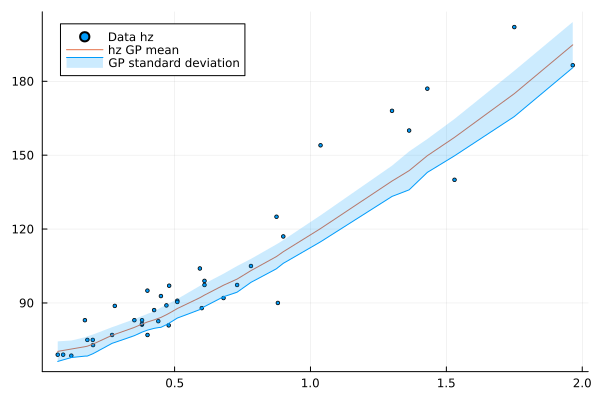

In [34]:
plot(z_obs[1:40], observations[1:40], label="Data hz", ms=2, seriestype=:scatter)
plot!(sort(z_obs[1:40]), sort(vec(hpmean)), label="hz GP mean")
plot!(sort(z_obs[1:40]), sort(vec(hpmean .- hps)),  fillrange = sort(vec(hpmean .+ hps)), fillalpha=0.2, c=1, label="GP standard deviation")

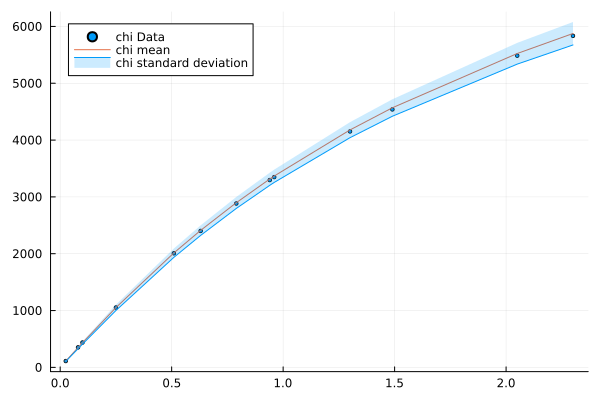

In [35]:
plot(z_obs[41:53], observations[41:53], label="chi Data", ms=2, seriestype=:scatter)
plot!(z_obs[41:53], vec(chipmean), label="chi mean")
plot!(z_obs[41:53], vec(chipmean .- chips),  fillrange = vec(chipmean .+ chips), fillalpha=0.2, c=1, label="chi standard deviation")

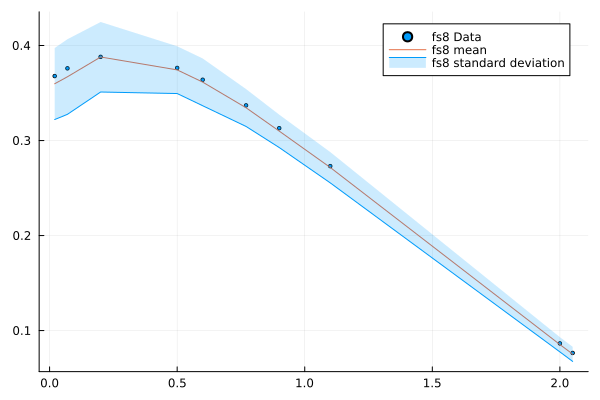

In [36]:
plot(z_obs[54:end], observations[54:end], label="fs8 Data", ms=2, seriestype=:scatter)
plot!(z_obs[54:end], vec(fs8pmean), label="fs8 mean")
plot!(z_obs[54:end], vec(fs8pmean .- fs8ps),  fillrange = vec(fs8pmean .+ fs8ps), fillalpha=0.2, c=1, label="fs8 standard deviation")

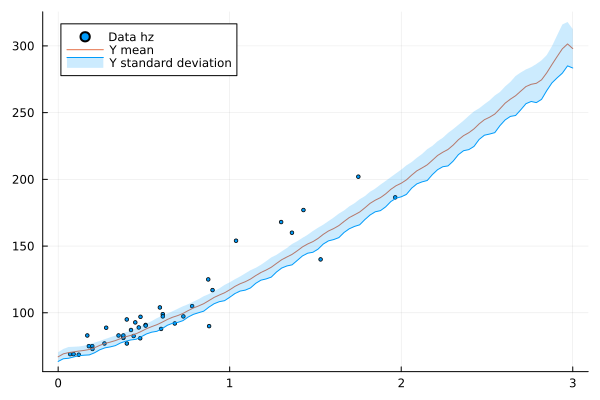

In [39]:
# posterior on H
plot(z_obs[1:40], observations[1:40], label="Data hz", ms=2, seriestype=:scatter)
plot!(z_integ, vec(y_m3), label="Y mean")
plot!(z_integ, vec(y_m3 .- y_s3),  fillrange = vec(y_m3 .+ y_s3), fillalpha=0.2, c=1, label="Y standard deviation")

In [42]:
# Hz integral interpolator - posterior
hz_itp2 = linear_interpolation(z_integ, vec(y_m3), extrapolation_bc=Line());
# chi interpolator - posterior
chiitp2 = comoving_d(z_integ, hz_itp2);
# fs8 posterior - interpolator
fs8itp2 = get_growth3(z_integ, mean(omegam_p), mean(s8_p), cosmo1.cpar.h, eltype(hz_itp2), hz_itp2);
     

100-element extrapolate(interpolate((::Vector{Float64},), ::Vector{Float64}, Gridded(Linear())), Line()) with element type Float64:
  0.35962537383020865
  0.3591268298507295
  0.35860414961290155
  0.3608501971140954
  0.3634479649543067
  0.3666261222507939
  0.3698892953627662
  0.37308536736453
  0.3761929163062584
  0.37938957012035057
  ⋮
 -0.02682593505040255
 -0.03629812265277111
 -0.04605436145593502
 -0.05576984808857203
 -0.06651741888714835
 -0.07669386232854924
 -0.08546109315812207
 -0.09410525085392506
 -0.1064345642420816

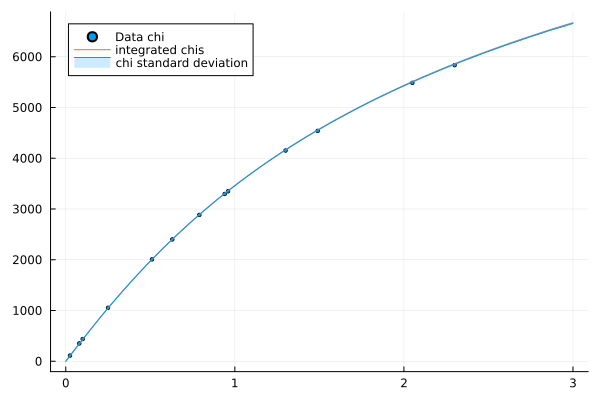

In [46]:
plot(bossdr12dm.z, bossdr12dm.data, label="Data chi", ms=2, seriestype=:scatter)
chivector_p = chiitp2(z_integ)
plot!(z_integ, chivector_p, label="integrated chis")
plot!(z_integ, (chivector_p-vec(y_s3)),  fillrange = (chivector_p+vec(y_s3)), fillalpha=0.2, c=1, label="chi standard deviation")
     

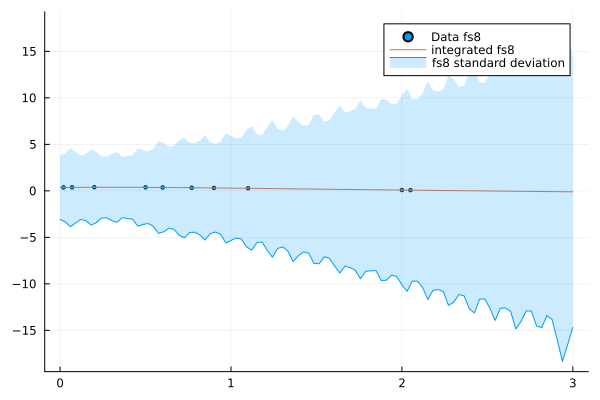

In [49]:
plot(fakedatafs8.z, fakedatafs8.data, label="Data fs8", ms=2, seriestype=:scatter)
fs8vector_p = fs8itp2(z_integ)
plot!(z_integ, fs8vector_p, label="integrated fs8")
plot!(z_integ, (fs8vector_p-vec(y_s3)),  fillrange = (fs8vector_p+vec(y_s3)), fillalpha=0.2, c=1, label="fs8 standard deviation")